------
# **Dementia Patients -- Analysis and Prediction**
### ***Author : Akhilesh Vyas***
### ****Date : August, 2019****



# ***Result Plots***

- <a href='#00'>0. Setup </a>
    - <a href='#00.1'>0.1. Load libraries </a>
    - <a href='#00.2'>0.2. Define paths </a>

- <a href='#01'>1. Data Preparation </a>  
    - <a href='#01.1'>1.1. Read Data </a> 
    - <a href='#01.2'>1.2. Prepare data  </a>
    - <a href='#01.3'>1.3. Prepare target </a>
    - <a href='#01.4'>1.4. Removing Unwanted Features </a>
    
- <a href='#02'>2. Data Analysis</a> 
    - <a href='#02.1'>2.1. Feature </a> 
    - <a href='#02.2'>2.2. Target </a> 
    
- <a href='#03'>3. Data Preparation and Vector Transformation</a>

- <a href='#04'>4. Analysis and Imputing Missing Values </a>

- <a href='#05'>5. Feature Analysis</a> 
    - <a href='#05.1'>5.1. Correlation Matrix</a>
    - <a href='#05.2'>5.2. Feature and target </a>
    - <a href='#05.3'>5.3. Feature Selection Models </a>
    
- <a href='#06'>6.Machine Learning -Classification Model</a> 

# <a id='00'>0. Setup </a>

# <a id='00.1'>0.1 Load libraries </a>

In [3]:
import sys
sys.path.insert(1, '../preprocessing/')
import numpy as np
import pickle
import scipy.stats as spstats
import matplotlib.pyplot as plt
#import seaborn as sns
#import pandas_profiling
from sklearn.utils import Bunch
#from data_transformation_cls import FeatureTransform
#from ast import literal_eval
#import plotly.figure_factory as ff
#import plotly.offline as py
#import plotly.graph_objects as go

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from ordered_set import OrderedSet

from func_def import *

%matplotlib inline

<ipython-input-3-447352da4680>:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# <a id='00.2'>0.2 Define paths </a>

In [4]:
# data_path
# !cp -r ../../../datalcdem/data/optima/dementia_18July/data_notasked/ ../../../datalcdem/data/optima/dementia_18July/data_notasked_mmse_0_30/
#data_path = '../../../datalcdem/data/optima/dementia_03_2020/data_filled_wiiliam/'
#result_path = '../../../datalcdem/data/optima/dementia_03_2020/data_filled_wiiliam/results/'
#optima_path = '../../../datalcdem/data/optima/optima_excel/'

data_path = '../../../../data_off/optima/dementia_data/'

In [5]:
# Reading Data

#patients data
patient_df = pd.read_csv(data_path+'patients.csv')
print (patient_df.dtypes)
# change dataType if there is something
for col in patient_df.columns: 
    if 'Date' in col:
        patient_df[col] = pd.to_datetime(patient_df[col]) 
 
patient_df = patient_df[['patient_id','gender', 'smoker', 'education', 'ageAtFirstEpisode', 'apoe']]
patient_df.rename(columns={'ageAtFirstEpisode':'age'}, inplace=True)
patient_df.head(5)

patient_id                   int64  
gender                       object 
dementia                     bool   
smoker                       object 
alcohol                      object 
education                    object 
bmi                          float64
weight                       float64
ageAtFirstEpisode            int64  
ageAtLastEpisode             int64  
malignantComorbidity         object 
systemicComorbidity          object 
cardiovascularComorbidity    bool   
metabolicComorbidity         bool   
infectiousComorbidity        bool   
neoplasticComorbidity        bool   
respiratoryComorbidity       bool   
neurologicalComorbidity      bool   
inflammatoryComorbidity      bool   
apoe                         object 
epDateInicial                object 
mmseInicial                  int64  
mmseInicialDiscretized       object 
epDateFinal                  object 
mmseFinal                    int64  
mmseFinalDiscretized         object 
epDateToSevereData           object 
e

,patient_id,gender,smoker,education,age,apoe
0,1,Male,smoker,medium,71,E3E3
1,14,Female,no_smoker,medium,79,E3E4
2,16,Male,no_smoker,higher,78,E3E4
3,19,Male,smoker,higher,56,E3E4
4,32,Male,no_smoker,higher,72,E3E3


# <a id='1'>1. Data Preparation </a> 

## <a id='01.1'>1.1. Read Data</a>

In [6]:
#Preparation Features from Raw data

# Extracting selected features from Raw data
def rename_columns(col_list):
    d = {}
    for i in col_list:
        if i=='GLOBAL_PATIENT_DB_ID':
            d[i]='patient_id'
        elif 'CAMDEX SCORES: ' in i:
            d[i]=i.replace('CAMDEX SCORES: ', '').replace(' ', '_')
        elif 'CAMDEX ADMINISTRATION 1-12: ' in i:
            d[i]=i.replace('CAMDEX ADMINISTRATION 1-12: ', '').replace(' ', '_')
        elif 'DIAGNOSIS 334-351: ' in i:
            d[i]=i.replace('DIAGNOSIS 334-351: ', '').replace(' ', '_')
        elif 'OPTIMA DIAGNOSES V 2010: ' in i:
            d[i]=i.replace('OPTIMA DIAGNOSES V 2010: ', '').replace(' ', '_')
        elif 'PM INFORMATION: ' in i:
            d[i]=i.replace('PM INFORMATION: ', '').replace(' ', '_')
        else:
            d[i]=i.replace(' ', '_')
    return d


columns_selected = ['GLOBAL_PATIENT_DB_ID', 'EPISODE_DATE', 'CAMDEX SCORES: MINI MENTAL SCORE', 'CLINICAL BACKGROUND: BODY MASS INDEX',  
          'DIAGNOSIS 334-351: ANXIETY/PHOBIC', 'OPTIMA DIAGNOSES V 2010: CERBRO-VASCULAR DISEASE PRESENT', 'DIAGNOSIS 334-351: DEPRESSIVE ILLNESS',
          'OPTIMA DIAGNOSES V 2010: DIAGNOSTIC CODE', 'CAMDEX ADMINISTRATION 1-12: EST OF SEVERITY OF DEPRESSION', 
           'CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', 'DIAGNOSIS 334-351: PRIMARY PSYCHIATRIC DIAGNOSES', 'OPTIMA DIAGNOSES V 2010: PETERSEN MCI']



columns_selected = list(OrderedSet(columns_selected).union(OrderedSet(features_all)))

# Need to think about other columns eg. dementia, social, sleeping habits, 
df_datarequest = pd.read_excel(data_path+'Optima_Data_Report_Cases_6511_filled.xlsx')
display(df_datarequest.head(1))
df_datarequest_features = df_datarequest[columns_selected]
display(df_datarequest_features.columns)

columns_renamed = rename_columns(df_datarequest_features.columns.tolist())
df_datarequest_features.rename(columns=columns_renamed, inplace=True)
patient_com_treat_fea_raw_df = df_datarequest_features # Need to be changed ------------------------
display(patient_com_treat_fea_raw_df.head(5))
           
# merging
patient_df = patient_com_treat_fea_raw_df.merge(patient_df,how='inner', on=['patient_id'])           
           
# age calculator
patient_df['age'] = patient_df['age'] + patient_df.groupby(by=['patient_id'])['EPISODE_DATE'].transform(lambda x: (x - x.iloc[0])/(np.timedelta64(1, 'D')*365.25))

# saving file
patient_df.to_csv(data_path + 'patient_com_treat_fea_filled_sel_col.csv', index=False)

           

# patient_com_treat_fea_raw_df = patient_com_treat_fea_raw_df.drop_duplicates(subset=['patient_id', 'EPISODE_DATE'])
patient_df.sort_values(by=['patient_id', 'EPISODE_DATE'], inplace=True)

display(patient_df.head(5))


,Unnamed: 0,GLOBAL_PATIENT_DB_ID,STUDY_ID,STUDY,DOD,Age At Episode,GENDER,EPISODE_DATE,EPISODE,CAMDEX ADMINISTRATION 1-12: DATE OF EXAMINATION,CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA,CAMDEX ADMINISTRATION 1-12: EST OF SEVERITY OF DEPRESSION,CAMDEX ADMINISTRATION 1-12: VISUALLY IMPAIRED,CAMDEX ADMINISTRATION 1-12: HARD OF HEARING,CAMDEX ADMINISTRATION 1-12: TOTALLY CARED FOR,CAMDEX ADMINISTRATION 1-12: OTHER SIGNIFICANT IMPAIRMENT,CAMDEX ADMINISTRATION 1-12: OTHER SIGNIFICANT IMPAIRMENT: TEXT,PRESENT STATE 13-46: PRESENT STATE 13-46,PRESENT STATE 13-46: (013) NAME KNOWN,PRESENT STATE 13-46: (014) AGE KNOWN,PRESENT STATE 13-46: (015) DATE OF BIRTH KNOWN,PRESENT STATE 13-46: (016) AGE LEFT SCHOOL,PRESENT STATE 13-46: (017) YEARS IN FURTHER EDUCATION,PRESENT STATE 13-46: (017) YEARS IN FURTHER EDUCATION: TEXT,PRESENT STATE 13-46: (018) LIVING ARRANGEMENTS,PRESENT STATE 13-46: (019) HEADACHE,PRESENT STATE 13-46: (020) DIZZYNESS,PRESENT STATE 13-46: (021) FALLS,PRESENT STATE 13-46: (022) TIA,PRESENT STATE 13-46: (023) FALLS ASLEEP,PRESENT STATE 13-46: (024) WAKEFUL,PRESENT STATE 13-46: (025) WAKES EARLY,PRESENT STATE 13-46: (025) WAKES EARLY: TEXT,PRESENT STATE 13-46: (026) APPETITE CHANGE,PRESENT STATE 13-46: (027) WEIGHT CHANGE,PRESENT STATE 13-46: (027) WEIGHT CHANGE: TEXT,PRESENT STATE 13-46: (028) COPING LESS,PRESENT STATE 13-46: (029) DECISION MAKING DIFFICULT,PRESENT STATE 13-46: (030) PLEASURE LOSS,PRESENT STATE 13-46: (031) ENERGY LOSS,PRESENT STATE 13-46: (032) ALONE PREFERENCE,PRESENT STATE 13-46: (033) CONCENTRATION DIFFICULT,PRESENT STATE 13-46: (034) SLOWED SPEECH,PRESENT STATE 13-46: (035) SLOWED THOUGHT,PRESENT STATE 13-46: (036) FEELING DEPRESSED,PRESENT STATE 13-46: (037) DURATION OF DEPRESSION,PRESENT STATE 13-46: (038) REASON FOR DEPRESSION,PRESENT STATE 13-46: (038) REASON FOR DEPRESSION: TEXT,PRESENT STATE 13-46: (039) DIFFERENT FROM SADNESS,PRESENT STATE 13-46: (040) CHEERS UP,PRESENT STATE 13-46: (041) DIURNAL CHANGE,PRESENT STATE 13-46: (042) BLAMES OTHERS,PRESENT STATE 13-46: (043) WORTHLESS OR GUILTY,PRESENT STATE 13-46: (044) FUTURE FEELINGS,PRESENT STATE 13-46: (045) NOT WORTH LIVING,PRESENT STATE 13-46: (046) SUICIDAL FEELINGS,PRESENT STATE 47-73: PRESENT STATE 47-73,PRESENT STATE 47-73: (047) WORRIES MORE,PRESENT STATE 47-73: (048) IRRITABLE,PRESENT STATE 47-73: (049) ANXIOUS,PRESENT STATE 47-73: (050) PHYSICAL SYMPTOMS,PRESENT STATE 47-73: (051) ANXIOUS SITUATIONS,PRESENT STATE 47-73: (051) ANXIOUS SITUATIONS: TEXT,PRESENT STATE 47-73: (052) PANIC ATTACKS,PRESENT STATE 47-73: (053) DURATION OF PANIC,PRESENT STATE 47-73: (054) MONEY HANDLING DIFFICULT,PRESENT STATE 47-73: (055) HOUSEHOLD TASKS DIFFICULT,PRESENT STATE 47-73: (056) BLADDER CONTROL DIFFICULT,PRESENT STATE 47-73: (057) PHYSICAL PROBLEMS,PRESENT STATE 47-73: (058) MEMORY PROBLEM,PRESENT STATE 47-73: (059) FORGETS OBJECTS,PRESENT STATE 47-73: (060) FORGETS NAMES,PRESENT STATE 47-73: (061) FORGETS WAY,PRESENT STATE 47-73: (062) DURATION OF MEMORY PROBLEMS,PRESENT STATE 47-73: (063) ONSET OF MEMORY PROBLEMS,PRESENT STATE 47-73: (064) CHANGE IN MEMORY PROBLEMS,PRESENT STATE 47-73: (065) REFERS MORE TO THE PAST,PRESENT STATE 47-73: (066) WORD FINDING DIFFICULTY,PRESENT STATE 47-73: (066) WORD FINDING DIFFICULTY: DURATION,PRESENT STATE 47-73: (068) AUDITORY HALLUCINATIONS,PRESENT STATE 47-73: (068) AUDITORY HALLUCINATIONS: DURATION,PRESENT STATE 47-73: (068) AUDITORY HALLUCINATIONS: TEXT,PRESENT STATE 47-73: (069) VISUAL HALLUCINATIONS,PRESENT STATE 47-73: (069) VISUAL HALLUCINATIONS: DURATION,PRESENT STATE 47-73: (069) VISUAL HALLUCINATIONS: TEXT,PRESENT STATE 47-73: (070) WATCHED OR SPIED ON,PRESENT STATE 47-73: (070) WATCHED OR SPIED ON: DURATION,PRESENT STATE 47-73: (071) PASSIVITY FEELINGS,PRESENT STATE 47-73: (071) PASSIVITY FEELINGS: DURATION,PRESENT STATE 47-73: (072) HYPOCHONDRIACAL DELUSIONS,PRESENT STATE 47-73: (072) HYPOCHONDRIACAL DELUSIONS: DURATION,PRESENT STATE 47-73: (073) ILLUSORY INTERFERENCE,PRESENT STATE 47-73: (

Index(['GLOBAL_PATIENT_DB_ID', 'EPISODE_DATE',
       'CAMDEX SCORES: MINI MENTAL SCORE',
       'CLINICAL BACKGROUND: BODY MASS INDEX',
       'DIAGNOSIS 334-351: ANXIETY/PHOBIC',
       'OPTIMA DIAGNOSES V 2010: CERBRO-VASCULAR DISEASE PRESENT',
       'DIAGNOSIS 334-351: DEPRESSIVE ILLNESS',
       'OPTIMA DIAGNOSES V 2010: DIAGNOSTIC CODE',
       'CAMDEX ADMINISTRATION 1-12: EST OF SEVERITY OF DEPRESSION',
       'CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA',
       ...
       'PRESENT STATE 47-73: (049) ANXIOUS',
       'PRESENT STATE 47-73: (051) ANXIOUS SITUATIONS',
       'INTERVIEWER OBS 188-212: (195) ANXIOUS OR FEARFUL',
       'MEDICAL ASSESSMENT V 2010: ANXIETY', 'NPI: ANXIETY: FREQUENCY',
       'NPI: ANXIETY: SEVERITY', 'NPI: ANXIETY: F X S',
       'NPI: ANXIETY: DISTRESS', 'GENERAL INFORMATION: ASPIRIN: DURATION',
       'GENERAL INFORMATION: ASPIRIN'],
      dtype='object', length=213)

/home/tibvyasa/miniconda3/envs/dtree/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_1

,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_1

<ipython-input-7-d550348330d9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(patient_df.describe(include='all'))


,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6510
Columns: 218 entries, patient_id to apoe
dtypes: datetime64[ns](1), float64(205), int64(5), object(7)
memory usage: 10.9+ MB


None

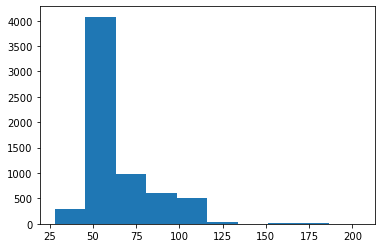

In [7]:
display(patient_df.describe(include='all'))
display(patient_df.info())

tmp_l = []
for i in range(len(patient_df.index)):
    # print("Nan in row ", i , " : " ,  patient_com_treat_fea_raw_df.iloc[i].isnull().sum())
    tmp_l.append(patient_df.iloc[i].isnull().sum())
    
plt.hist(tmp_l)
plt.show()

In [8]:
'''patient_df['gender'] = patient_df['gender'].replace(['Male', 'Female'],[1, 0])
patient_df['apoe'] = patient_df['apoe'].replace(['E2E2', 'E2E3', 'E2E4', 'E3E3', 'E3E4','E4E4',
       '_E3E3', 'TBD'],[1,2,3,4,5,6,4,7])'''

patient_df = pd.get_dummies(patient_df, columns=['gender', 'apoe'])
patient_df['smoker'] = patient_df['smoker'].replace(['smoker', 'no_smoker'],[1, 0])
patient_df['education'] = patient_df['education'].replace(['basic', 'medium', 'higher',],[0, 1, 2])
patient_df.replace(['mixed mitral & Aortic Valve disease', 'Bilateral knee replacements'],[np.nan, np.nan], inplace=True)
patient_df['durations(years)'] = patient_df.groupby(by='patient_id')['EPISODE_DATE'].transform(lambda x: (x - x.iloc[0])/(np.timedelta64(1, 'D')*365.25))
patient_df['MINI_MENTAL_SCORE_PRE'] = patient_df.groupby(by='patient_id')['MINI_MENTAL_SCORE'].transform(lambda x: x.shift(+1))

for i, j in zip(patient_df, patient_df.dtypes):
    if not (j == "float64" or j == "int64" or j == 'uint8' or j == 'datetime64[ns]'):
        print(i)
        patient_df[i] = pd.to_numeric(patient_df[i], errors='coerce')

# changing filling criteria
patient_eps = patient_df['EPISODE_DATE']
patient_ids = patient_df['patient_id']
patient_df = patient_df.drop(columns='EPISODE_DATE')
patient_df = patient_df.groupby(by='patient_id').transform(lambda x: x.interpolate(method='ffill'))
                                                           #.interpolate(method='bfill'))
patient_df['patient_id'] = patient_ids
patient_df['EPISODE_DATE'] = patient_eps

#patient_df = patient_df.fillna(-1)

patient_df.to_csv(data_path+'patient_df_rnn.csv', index=False)

ANXIETY/PHOBIC
DEPRESSIVE_ILLNESS
SEVERITY_OF_DEPRESSION


In [9]:
# find NAN and Notasked and replace them with suitable value
'''print (patient_df.columns.tolist())
notasked_columns = ['ANXIETY/PHOBIC', 'CERBRO-VASCULAR_DISEASE_PRESENT', 'DEPRESSIVE_ILLNESS','EST_OF_SEVERITY_OF_DEPRESSION', 'EST_SEVERITY_OF_DEMENTIA', 
                    'PRIMARY_PSYCHIATRIC_DIAGNOSES']
print ('total nan values %: ', 100*patient_df.isna().sum().sum()/patient_df.size)
patient_df.loc[:, notasked_columns] =  patient_df.loc[:, notasked_columns].replace([9], [np.nan])
print ('total nan values % after considering notasked: ', 100*patient_df.isna().sum().sum()/patient_df.size)
display(patient_df.isna().sum())
notasked_columns.append('DIAGNOSTIC_CODE')
notasked_columns.append('education')
patient_df.loc[:, notasked_columns] = patient_df.groupby(by=['patient_id'])[notasked_columns].transform(lambda x: x.fillna(method='pad'))
patient_df.loc[:, ['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']] = patient_df.groupby(by=['patient_id'])[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].transform(lambda x: x.interpolate())
patient_df.loc[:, ['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']] = patient_df.groupby(by=['patient_id'])[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].transform(lambda x: x.fillna(method='pad'))
print ('total nan values % after filling : ', 100*patient_df.isna().sum().sum()/patient_df.size)
display(patient_df.isna().sum())'''

"print (patient_df.columns.tolist())\nnotasked_columns = ['ANXIETY/PHOBIC', 'CERBRO-VASCULAR_DISEASE_PRESENT', 'DEPRESSIVE_ILLNESS','EST_OF_SEVERITY_OF_DEPRESSION', 'EST_SEVERITY_OF_DEMENTIA', \n                    'PRIMARY_PSYCHIATRIC_DIAGNOSES']\nprint ('total nan values %: ', 100*patient_df.isna().sum().sum()/patient_df.size)\npatient_df.loc[:, notasked_columns] =  patient_df.loc[:, notasked_columns].replace([9], [np.nan])\nprint ('total nan values % after considering notasked: ', 100*patient_df.isna().sum().sum()/patient_df.size)\ndisplay(patient_df.isna().sum())\nnotasked_columns.append('DIAGNOSTIC_CODE')\nnotasked_columns.append('education')\npatient_df.loc[:, notasked_columns] = patient_df.groupby(by=['patient_id'])[notasked_columns].transform(lambda x: x.fillna(method='pad'))\npatient_df.loc[:, ['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']] = patient_df.groupby(by=['patient_id'])[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].transform(lambda x: x.interpolate())\npatient_df.loc[:, ['CLIN

In [10]:
# Label of patients:
misdiagnosed_df = pd.read_csv(data_path+'misdiagnosed.csv')
display(misdiagnosed_df.head(5))

misdiagnosed_df['EPISODE_DATE'] = pd.to_datetime(misdiagnosed_df['EPISODE_DATE'])

#Merge Patient_df
patient_df = patient_df.merge(misdiagnosed_df[['patient_id', 'EPISODE_DATE', 'Misdiagnosed','Misdiagnosed1']], how='left', on=['patient_id', 'EPISODE_DATE'])
display(patient_df.head(5))

,patient_id,EPISODE_DATE,PETERSEN_MCI,MINI_MENTAL_SCORE,PSYCHIATRIC,AD_STATUS,MINI_MENTAL_SCORE_CATEGORY,lineNumber,durations(years),MINI_MENTAL_SCORE_CATEGORY(+MCI),State_Update(years),MMSE_Change,Misdiagnosed,Misdiagnosed1
0,1,1998-01-13,0.0,30.0,0.0,0.0,Normal,1,0.000000,Normal,NaN,NaN,UNKNOWN,UNKNOWN
1,1,2000-01-20,0.0,30.0,9.0,0.0,Normal,2,2.019178,Normal,2.019178,0.0,UNKNOWN,UNKNOWN
2,1,2002-02-21,0.0,30.0,NaN,0.0,Normal,3,4.109589,Normal,2.090411,0.0,UNKNOWN,UNKNOWN
3,1,2002-10-28,0.0,29.0,NaN,0.0,Normal,4,4.791781,Normal,0.682192,-1.0,UNKNOWN,UNKNOWN
4,1,2004-06-22,0.0,30.0,NaN,0.0,Normal,5,6.443836,Normal,1.652055,1.0,UNKNOWN,UNKNOWN


,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

In [11]:
patient_df.to_csv(data_path+'patient_df.csv', index=False)

In [12]:
patient_df = pd.read_csv(data_path+'patient_df.csv')
patient_df['EPISODE_DATE'] = pd.to_datetime(patient_df['EPISODE_DATE'])

In [13]:
# duration and previous mini mental score state
'''patient_df['durations(years)'] = patient_df.groupby(by='patient_id')['EPISODE_DATE'].transform(lambda x: (x - x.iloc[0])/(np.timedelta64(1, 'D')*365.25))
patient_df['MINI_MENTAL_SCORE_PRE'] = patient_df.groupby(by='patient_id')['MINI_MENTAL_SCORE'].transform(lambda x: x.shift(+1))'''

"patient_df['durations(years)'] = patient_df.groupby(by='patient_id')['EPISODE_DATE'].transform(lambda x: (x - x.iloc[0])/(np.timedelta64(1, 'D')*365.25))\npatient_df['MINI_MENTAL_SCORE_PRE'] = patient_df.groupby(by='patient_id')['MINI_MENTAL_SCORE'].transform(lambda x: x.shift(+1))"

In [14]:
patient_df[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].describe() # Out of Range values

,CLINICAL_BACKGROUND:_BODY_MASS_INDEX
count,4242.000000
mean,27.032107
std,85.792327
min,0.000000
25%,22.800000
50%,25.300000
75%,28.100000
max,5600.000000


In [15]:
patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX'][(patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']>54) | (patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']<8)]=np.nan

<ipython-input-15-b7848b95951f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX'][(patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']>54) | (patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']<8)]=np.nan


In [16]:
patient_df[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].describe()

,CLINICAL_BACKGROUND:_BODY_MASS_INDEX
count,4202.000000
mean,25.737078
std,3.999499
min,14.500000
25%,22.900000
50%,25.300000
75%,28.100000
max,52.100000


In [17]:
# drop unnecessary columns
# patient_df.drop(columns=['patient_id', 'EPISODE_DATE'], inplace=True)

In [18]:
# drop rows where Misdiagnosed cases are invalid
patient_df = patient_df.dropna(subset=['MINI_MENTAL_SCORE_PRE'], axis=0 )


In [19]:
#patient_df['gender'].unique(), patient_df['smoker'].unique(), patient_df['education'].unique(), patient_df['apoe'].unique(), patient_df['Misdiagnosed1'].unique(), patient_df['Misdiagnosed'].unique()

In [20]:
# encoding of categorial features
'''patient_df['smoker'] = patient_df['smoker'].replace(['smoker', 'no_smoker'],[1, 0])
patient_df['education'] = patient_df['education'].replace(['basic', 'medium', 'higher',],[0, 1, 2])
patient_df = pd.get_dummies(patient_df, columns=['gender', 'apoe'])
patient_df.replace(['mixed mitral & Aortic Valve disease', 'Bilateral knee replacements'],[np.nan, np.nan], inplace=True)'''
patient_df['Misdiagnosed1'] = patient_df['Misdiagnosed1'].replace(['NO', 'YES', 'UNKNOWN'],[0, 1, 2])
patient_df['Misdiagnosed'] = patient_df['Misdiagnosed'].replace(['NO', 'YES', 'UNKNOWN'],[0, 1, 2])


In [21]:
patient_df.dtypes

MINI_MENTAL_SCORE                                                int64         
CLINICAL_BACKGROUND:_BODY_MASS_INDEX                             float64       
ANXIETY/PHOBIC                                                   float64       
CERBRO-VASCULAR_DISEASE_PRESENT                                  float64       
DEPRESSIVE_ILLNESS                                               float64       
DIAGNOSTIC_CODE                                                  float64       
EST_OF_SEVERITY_OF_DEPRESSION                                    float64       
EST_SEVERITY_OF_DEMENTIA                                         float64       
PRIMARY_PSYCHIATRIC_DIAGNOSES                                    float64       
PETERSEN_MCI                                                     float64       
PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL                       float64       
MOCA:_YEARS_OF_EDUCATION                                         float64       
PRESENT_STATE_13-46:_(017)_YEARS_IN_FURT

In [22]:
for i, j in zip(patient_df, patient_df.dtypes):
    if not (j == "float64" or j == "int64" or j == 'uint8' or j == 'datetime64[ns]'):
        print(i)
        patient_df[i] = pd.to_numeric(patient_df[i], errors='coerce')

patient_df = patient_df.fillna(-1)

In [23]:
# Misdiagnosed Criteria
patient_df = patient_df[patient_df['Misdiagnosed']<2]
patient_df = patient_df.astype({col: str('float64') for col, dtype in zip (patient_df.columns.tolist(), patient_df.dtypes.tolist()) if 'int' in str(dtype) or str(dtype)=='object'})
patient_df.describe()

,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

In [24]:
# dropping MINI_MENTAL_SCORE_PRE
patient_df_X = patient_df.drop(columns=['patient_id', 'EPISODE_DATE', 'Misdiagnosed1', 'MINI_MENTAL_SCORE', 'PETERSEN_MCI', 'Misdiagnosed', 'MINI_MENTAL_SCORE_PRE'])
patient_df_y_cat = patient_df['Misdiagnosed1']
patient_df_y_cat_s = patient_df['Misdiagnosed']
patient_df_y_real = patient_df['MINI_MENTAL_SCORE']

In [25]:
print (patient_df_X.shape, patient_df_y_cat.shape, patient_df_y_cat_s.shape, patient_df_y_real.shape)
print(patient_df_X.shape, patient_df_y_cat.shape, patient_df_y_cat_s.shape, patient_df_y_real.shape)

(1104, 223) (1104,) (1104,) (1104,)
(1104, 223) (1104,) (1104,) (1104,)


In [26]:
# training data
patient_df_X_fill_data = pd.DataFrame(data=patient_df_X.values, columns=patient_df_X.columns, index=patient_df_X.index)

patient_df_X_train, patient_df_y_train = patient_df_X_fill_data[patient_df_y_cat==0], patient_df_y_real[patient_df_y_cat==0]
patient_df_X_test, patient_df_y_test= patient_df_X_fill_data[patient_df_y_cat==1], patient_df_y_real[patient_df_y_cat==1]

patient_df_X_s_train, patient_df_y_s_train = patient_df_X_fill_data[patient_df_y_cat_s==0], patient_df_y_real[patient_df_y_cat_s==0]
patient_df_X_s_test, patient_df_y_s_test= patient_df_X_fill_data[patient_df_y_cat_s==1], patient_df_y_real[patient_df_y_cat_s==1]


In [27]:
patient_df_X_train.to_csv(data_path+'X_train.csv', index=False)
patient_df_y_train.to_csv(data_path+'y_train.csv', index=False)
patient_df_X_test.to_csv(data_path+'X_test.csv', index=False)
patient_df_y_test.to_csv(data_path+'y_test.csv', index=False)

In [28]:
print(patient_df_X_train.shape, patient_df_y_train.shape, patient_df_X_test.shape, patient_df_y_test.shape)
print(patient_df_X_s_train.shape, patient_df_y_s_train.shape, patient_df_X_s_test.shape, patient_df_y_s_test.shape)

(971, 223) (971,) (133, 223) (133,)
(1080, 223) (1080,) (24, 223) (24,)


In [29]:
X_train, y_train, X_test, y_test = patient_df_X_train.values, patient_df_y_train.values.reshape(-1, 1),patient_df_X_test.values, patient_df_y_test.values.reshape(-1,1)

X_s_train, y_s_train, X_s_test, y_s_test = patient_df_X_s_train.values, patient_df_y_s_train.values.reshape(-1, 1),patient_df_X_s_test.values, patient_df_y_s_test.values.reshape(-1,1)

In [45]:
patient_df_X_fill_data

Index(['CLINICAL_BACKGROUND:_BODY_MASS_INDEX', 'ANXIETY/PHOBIC',
       'CERBRO-VASCULAR_DISEASE_PRESENT', 'DEPRESSIVE_ILLNESS',
       'DIAGNOSTIC_CODE', 'EST_OF_SEVERITY_OF_DEPRESSION',
       'EST_SEVERITY_OF_DEMENTIA', 'PRIMARY_PSYCHIATRIC_DIAGNOSES',
       'PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL',
       'MOCA:_YEARS_OF_EDUCATION',
       ...
       'gender_Male', 'apoe_E2E2', 'apoe_E2E3', 'apoe_E2E4', 'apoe_E3E3',
       'apoe_E3E4', 'apoe_E4E4', 'apoe_TBD', 'apoe__E3E3', 'durations(years)'],
      dtype='object', length=223)

/home/tibvyasa/miniconda3/envs/dtree/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tibvyasa/miniconda3/envs/dtree/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.16463256, 0.14587808, 0.14664054, 0.14079165, 0.13944674]), 'score_time': array([0.01328468, 0.01550841, 0.01277065, 0.01252198, 0.01296306]), 'test_recall_macro': array([0.5       , 0.55603284, 0.55040092, 0.52415044, 0.5       ]), 'test_precision_macro': array([0.44117647, 0.62705628, 0.74444444, 0.58444593, 0.44090909]), 'test_f1_macro': array([0.46875   , 0.56813445, 0.56204268, 0.52205882, 0.46859903]), 'test_accuracy': array([0.88235294, 0.86425339, 0.88235294, 0.86425339, 0.88181818])}
              precision    recall  f1-score   support

          NO       0.89      0.98      0.93       971
         YES       0.46      0.10      0.16       133

    accuracy                           0.88      1104
   macro avg       0.68      0.54      0.55      1104
weighted avg       0.84      0.88      0.84      1104

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       292
         1.0       0.32      0.30      0.31 

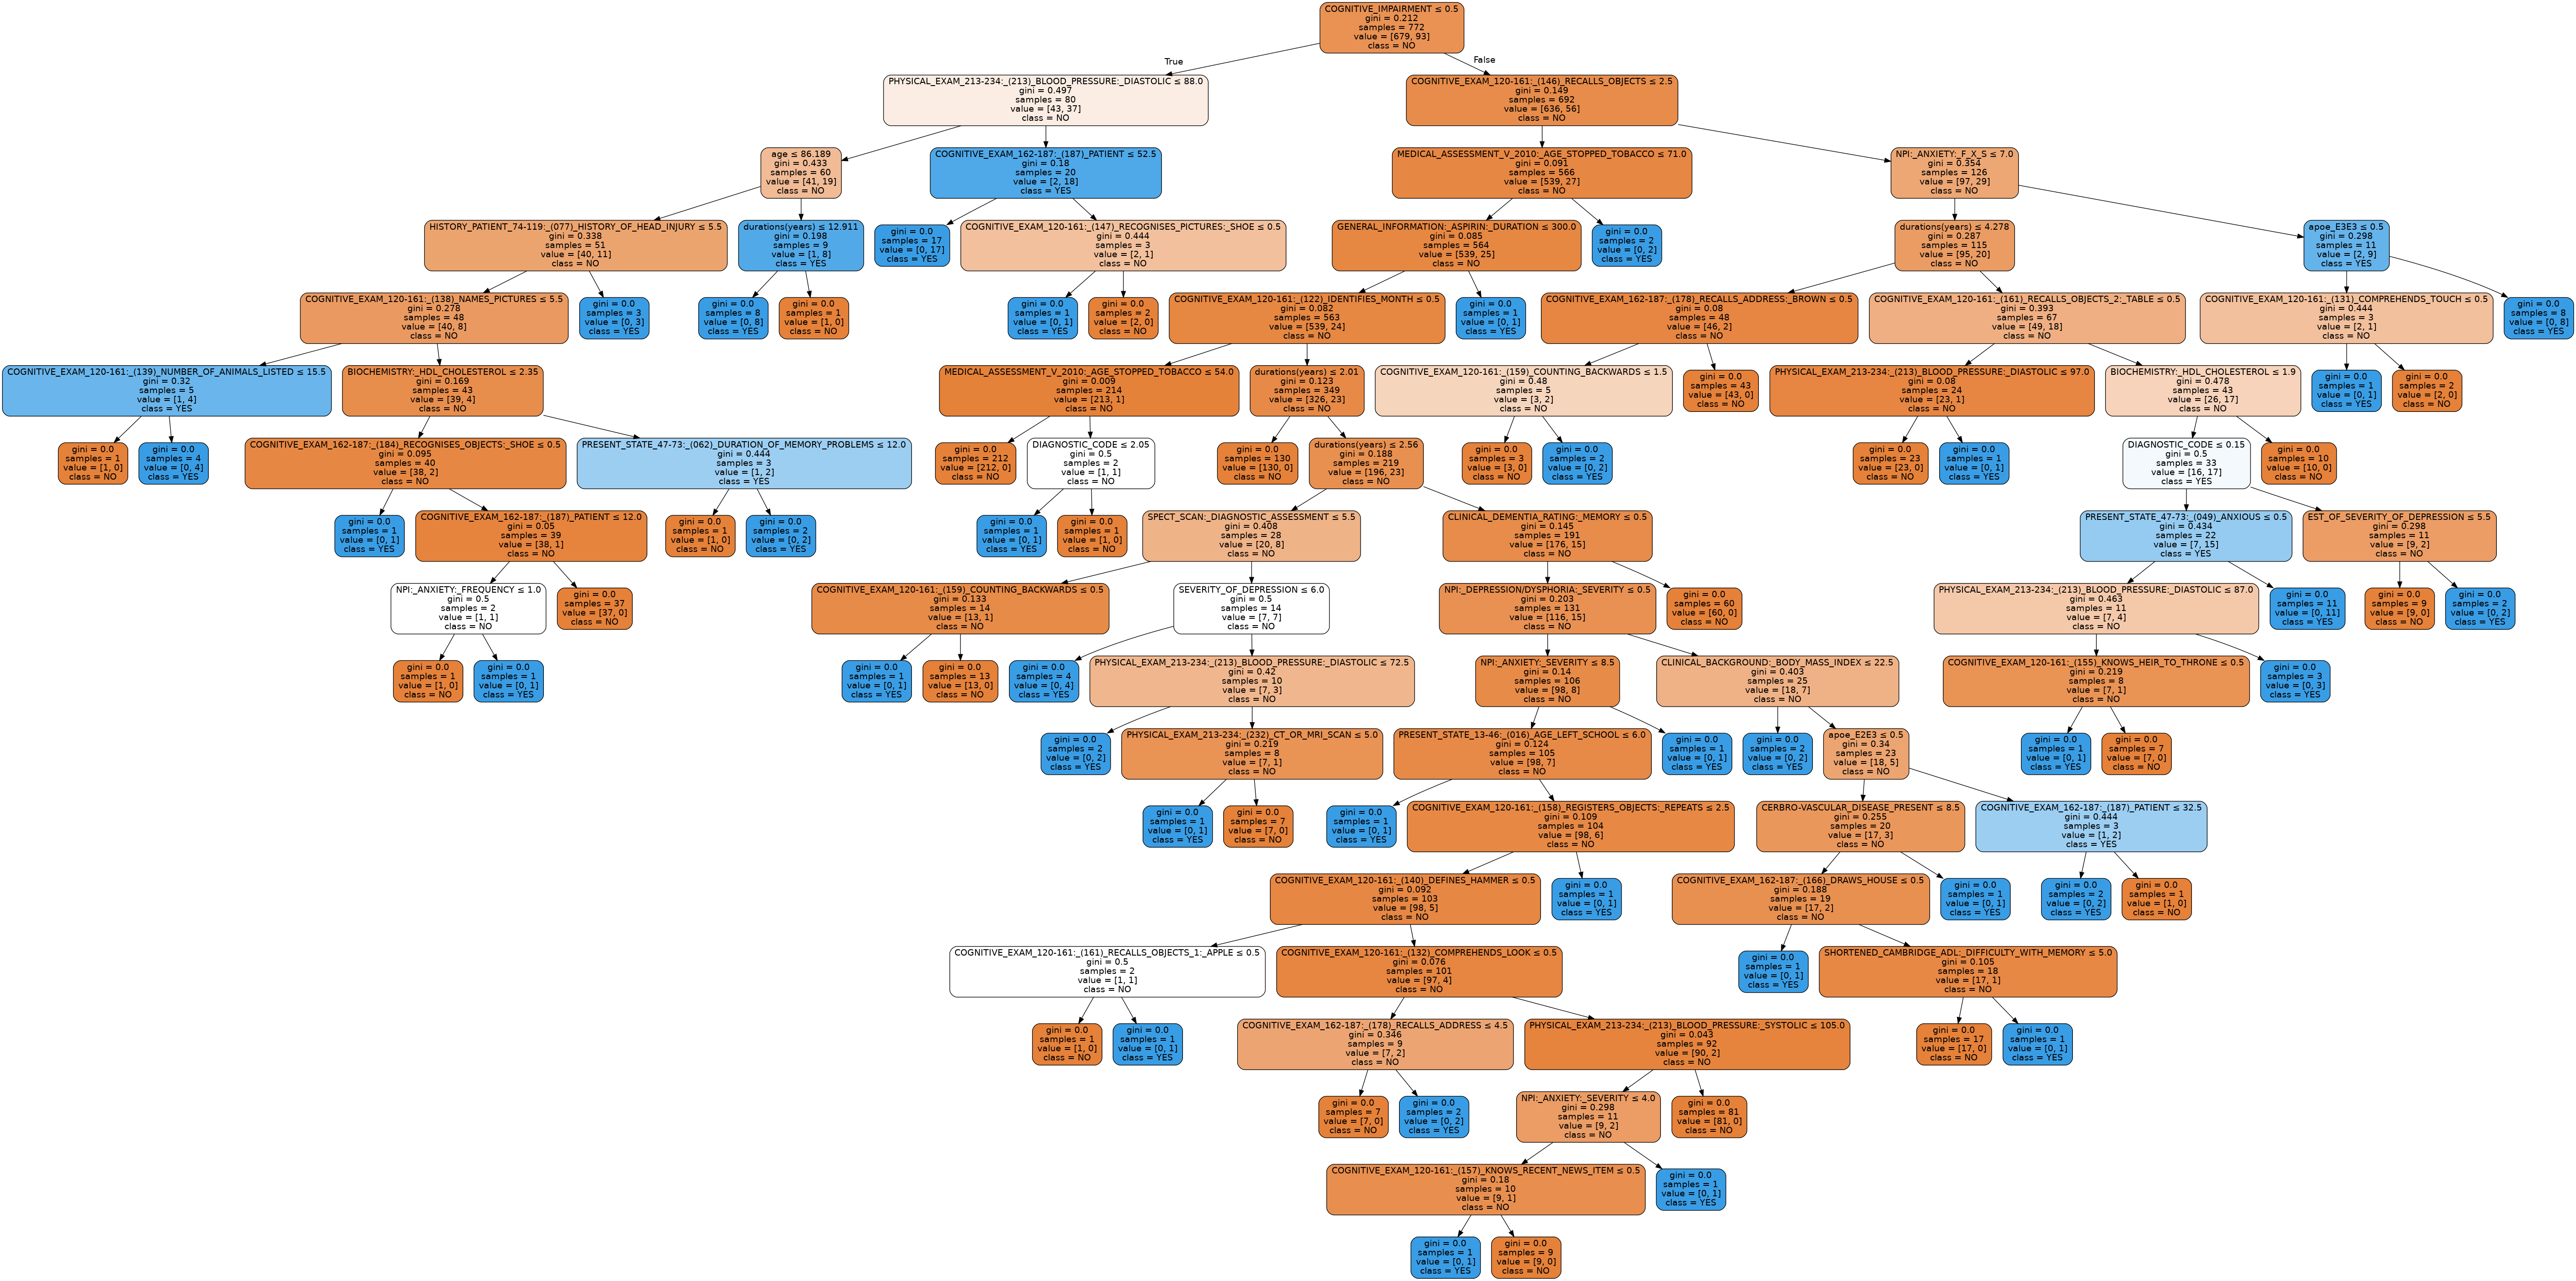

In [48]:
# Random Forest Classfier

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import classification_report
# patient_df_X_fill_data[patient_df_y_cat==0]
X, y = patient_df_X_fill_data, patient_df_y_cat
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))


import graphviz
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus, joblib
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

X_train, X_test, y_train, y_test = train_test_split(patient_df_X_fill_data.values, patient_df_y_cat.values, test_size=0.3, random_state=42, stratify=patient_df_y_cat)

feature_names = patient_df_X_fill_data.columns

clf = tree.DecisionTreeClassifier(random_state=0).fit(X_train, y_train) 
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print (classification_report(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names, 
               class_names=['NO', 'YES'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto')
data_p_s, target_p_s = smote.fit_resample(patient_df_X_fill_data, patient_df_y_cat)
print (data_p_s.shape, target_p_s.shape)
# patient_df_X_fill_data[patient_df_y_cat==0]
X, y = data_p_s,  target_p_s
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

In [ ]:
from collections import Counter
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(patient_df_X_fill_data, patient_df_y_cat)
print(sorted(Counter(y_resampled).items()))
X, y = X_resampled,  y_resampled
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(patient_df_X_fill_data, patient_df_y_cat)
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

In [33]:
X_positive, y_positive, X_negative, y_negative = patient_df_X_train, patient_df_y_train, patient_df_X_test, patient_df_y_test

In [34]:
cr_score_list = []
cm_score_list = []
imp_fea_list = []
y_true_5, y_pred_5 = np.array([]), np.array([])
y_true_5.shape, y_pred_5.shape

((0,), (0,))

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

loo = KFold(shuffle=True)
for train_index, test_index in loo.split(X_positive):
#for i in range(5):
    # X_train, X_test_pos, y_train, y_test_pos = train_test_split(X_positive, y_positive, test_size=0.2)
    X_train, X_test_pos, y_train, y_test_pos = \
    X_positive.iloc[train_index],X_positive.iloc[test_index], y_positive.iloc[train_index], y_positive.iloc[test_index]
    print (X_train.shape, X_test_pos.shape, y_train.shape, y_test_pos.shape)
    X_test, y_test = np.append(X_negative, X_test_pos, axis=0), np.append(y_negative, y_test_pos, axis=0)
    #X_test, y_test = X_negative, y_negative
    print (X_test.shape, y_test.shape)

    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(X_train, y_train)
    imp_fea_dict = {i:j for i, j in zip(X_positive.columns, regr.feature_importances_)}
    imp_fea_dict_sort = {k: v for k, v in sorted(imp_fea_dict.items(), key=lambda item: item[1], reverse=True)}
    for i, j in enumerate(imp_fea_dict_sort.items()):
        if i ==10:
            break
        imp_fea_list.append(j[0])
        print(j[0], end=' ')
    

    y_pred = regr.predict(X_test)
    #print(regr.predict(X_test))
    print ()
    print (regr.score(X_negative, y_negative))
    print (regr.score(X_test_pos, y_test_pos))
    print (regr.score(X_train, y_train))
    

    X_y_test = np.append(X_test, y_pred.reshape(-1,1), axis=1)
    print (X_test.shape, y_test.shape, X_y_test.shape)
    df_X_y_test = pd.DataFrame(data=X_y_test, columns=patient_df_X_fill_data.columns.tolist()+['MMSE_Predicted'])
    df_X_y_test.head(5)

    # Merge with patient_df and df_X_y_test
    p_tmp = patient_df.merge(df_X_y_test)
    print (patient_df.shape, df_X_y_test.shape, p_tmp.shape)
    display (p_tmp.head(5))
    
    

    # Compare it with Predicted MMSE Scores and True MMSE values
    patient_df_misdiag = pd.read_csv(data_path+'misdiagnosed.csv')
    patient_df_misdiag['EPISODE_DATE'] = pd.to_datetime(patient_df_misdiag['EPISODE_DATE'])
    patient_df_misdiag.head(5)

    patient_df_misdiag_predmis = patient_df_misdiag.merge(p_tmp[['patient_id', 'EPISODE_DATE', 'MMSE_Predicted']], how='outer', on=['patient_id', 'EPISODE_DATE'])
    patient_df_misdiag_predmis.head(5)
    display(patient_df_misdiag_predmis.isna().sum())

    index_MMSE_Predicted = patient_df_misdiag_predmis['MMSE_Predicted'].notnull()
    patient_df_misdiag_predmis['MMSE_Predicted'] = patient_df_misdiag_predmis['MMSE_Predicted'].fillna(patient_df_misdiag_predmis['MINI_MENTAL_SCORE'])

    print (sum(patient_df_misdiag_predmis['MMSE_Predicted']!=patient_df_misdiag_predmis['MINI_MENTAL_SCORE']))

    # find Misdiagnosed

    def find_misdiagonsed1():
        k = 0
        l_misdiagno = []
        for pat_id in patient_df_misdiag_predmis['patient_id'].unique():
            tmp_df = patient_df_misdiag_predmis[['PETERSEN_MCI', 'AD_STATUS', 'MMSE_Predicted', 'durations(years)']][patient_df_misdiag_predmis['patient_id']==pat_id]
            flag = False
            mms_val = 0.0
            dur_val = 0.0
            for i, row in tmp_df.iterrows():
                if (row[0]==1.0 or row[1]== 1.0) and flag==False:
                    l_misdiagno.append('UNKNOWN')
                    mms_val = row[2]
                    dur_val = row[3]
                    flag = True
                elif (flag==True):
                    if (row[2]-mms_val>5.0) and (row[3]-dur_val<=1.0) or\
                       (row[2]-mms_val>3.0) and ((row[3]-dur_val<2.0 and row[3]-dur_val>1.0)) or\
                       (row[2]-mms_val>0.0) and (row[3]-dur_val>=2.0):
                        l_misdiagno.append('YES')
                    else:
                        l_misdiagno.append('NO')
                else:
                    l_misdiagno.append('UNKNOWN')

        return l_misdiagno



    print (len(find_misdiagonsed1()))
    patient_df_misdiag_predmis['Misdiagnosed_Predicted'] = find_misdiagonsed1()

    c2=patient_df_misdiag_predmis['Misdiagnosed1']!=patient_df_misdiag_predmis['Misdiagnosed_Predicted']
    misdiagnosed1_true_pred= patient_df_misdiag_predmis[index_MMSE_Predicted][['Misdiagnosed1', 'Misdiagnosed_Predicted']].replace(['NO', 'YES'], [0,1])
    print(classification_report(misdiagnosed1_true_pred.Misdiagnosed1, misdiagnosed1_true_pred.Misdiagnosed_Predicted, target_names=['NO', 'YES']))
    d = classification_report(misdiagnosed1_true_pred.Misdiagnosed1, misdiagnosed1_true_pred.Misdiagnosed_Predicted, target_names=['NO', 'YES'], output_dict=True)
    cr_score_list.append(d)
    d1 = confusion_matrix(misdiagnosed1_true_pred.Misdiagnosed1, misdiagnosed1_true_pred.Misdiagnosed_Predicted)
    cm_score_list.append(d1)
    y_true_5, y_pred_5 = np.append(y_true_5, misdiagnosed1_true_pred.Misdiagnosed1, axis=0), np.append(y_pred_5, misdiagnosed1_true_pred.Misdiagnosed_Predicted, axis=0)

print(y_true_5.shape, y_pred_5.shape)

(776, 223) (195, 223) (776,) (195,)
(328, 223) (328,)
COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER COGNITIVE_EXAM_162-187:_(179)_SIMILARITIES_-_FRUIT EST_SEVERITY_OF_DEMENTIA COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH 
-0.9693694977028173
0.7351375793211639
0.7200736185788529
(328, 223) (328,) (328, 224)
(1104, 230) (328, 224) (328, 231)


,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

patient_id                          0   
EPISODE_DATE                        0   
PETERSEN_MCI                        22  
MINI_MENTAL_SCORE                   0   
PSYCHIATRIC                         3074
AD_STATUS                           22  
MINI_MENTAL_SCORE_CATEGORY          0   
lineNumber                          0   
durations(years)                    0   
MINI_MENTAL_SCORE_CATEGORY(+MCI)    0   
State_Update(years)                 1028
MMSE_Change                         1028
Misdiagnosed                        0   
Misdiagnosed1                       0   
MMSE_Predicted                      6183
dtype: int64

328
6511
              precision    recall  f1-score   support

          NO       0.72      0.99      0.83       195
         YES       0.98      0.43      0.60       133

    accuracy                           0.77       328
   macro avg       0.85      0.71      0.72       328
weighted avg       0.83      0.77      0.74       328

(777, 223) (194, 223) (777,) (194,)
(327, 223) (327,)
COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES 
-0.7762129566780327
0.7873447197201566
0.7214322355385911
(327, 223) (327,) (327, 224)
(1104, 230) (327, 224) (327, 231)


,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

patient_id                          0   
EPISODE_DATE                        0   
PETERSEN_MCI                        22  
MINI_MENTAL_SCORE                   0   
PSYCHIATRIC                         3074
AD_STATUS                           22  
MINI_MENTAL_SCORE_CATEGORY          0   
lineNumber                          0   
durations(years)                    0   
MINI_MENTAL_SCORE_CATEGORY(+MCI)    0   
State_Update(years)                 1028
MMSE_Change                         1028
Misdiagnosed                        0   
Misdiagnosed1                       0   
MMSE_Predicted                      6184
dtype: int64

327
6511
              precision    recall  f1-score   support

          NO       0.72      0.97      0.83       194
         YES       0.91      0.46      0.61       133

    accuracy                           0.76       327
   macro avg       0.82      0.71      0.72       327
weighted avg       0.80      0.76      0.74       327

(777, 223) (194, 223) (777,) (194,)
(327, 223) (327,)
COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS 
-0.9014924057354379
0.739943732383011
0.7242276398262004
(327, 223) (327,) (327, 224)
(1104, 230) (327, 224) (327, 231)


,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

patient_id                          0   
EPISODE_DATE                        0   
PETERSEN_MCI                        22  
MINI_MENTAL_SCORE                   0   
PSYCHIATRIC                         3074
AD_STATUS                           22  
MINI_MENTAL_SCORE_CATEGORY          0   
lineNumber                          0   
durations(years)                    0   
MINI_MENTAL_SCORE_CATEGORY(+MCI)    0   
State_Update(years)                 1028
MMSE_Change                         1028
Misdiagnosed                        0   
Misdiagnosed1                       0   
MMSE_Predicted                      6184
dtype: int64

327
6511
              precision    recall  f1-score   support

          NO       0.71      0.95      0.82       194
         YES       0.87      0.44      0.59       133

    accuracy                           0.75       327
   macro avg       0.79      0.70      0.70       327
weighted avg       0.78      0.75      0.72       327

(777, 223) (194, 223) (777,) (194,)
(327, 223) (327,)
COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER COGNITIVE_EXAM_162-187:_(178)_RECALLS_ADDRESS COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS_1:_APPLE COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS 
-0.6503353429078504
0.5302268408061763
0.7562495819333588
(327, 223) (327,) (327, 224)
(1104, 230) (327, 224) (327, 231

,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

patient_id                          0   
EPISODE_DATE                        0   
PETERSEN_MCI                        22  
MINI_MENTAL_SCORE                   0   
PSYCHIATRIC                         3074
AD_STATUS                           22  
MINI_MENTAL_SCORE_CATEGORY          0   
lineNumber                          0   
durations(years)                    0   
MINI_MENTAL_SCORE_CATEGORY(+MCI)    0   
State_Update(years)                 1028
MMSE_Change                         1028
Misdiagnosed                        0   
Misdiagnosed1                       0   
MMSE_Predicted                      6184
dtype: int64

327
6511
              precision    recall  f1-score   support

          NO       0.72      0.95      0.82       194
         YES       0.86      0.45      0.59       133

    accuracy                           0.75       327
   macro avg       0.79      0.70      0.70       327
weighted avg       0.77      0.75      0.72       327

(777, 223) (194, 223) (777,) (194,)
(327, 223) (327,)
COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK 
-0.8777338783906388
0.715785505531026
0.7321580154460358
(327, 223) (327,) (327, 224)
(1104, 230) (327, 224) (327

,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL,MOCA:_YEARS_OF_EDUCATION,PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION,HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE,MEDICAL_ASSESSMENT_V_2010:_STROKE,HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE,GENERAL_INFORMATION:_DIABETES:_DURATION,GENERAL_INFORMATION:_DIABETES,PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED,INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD,SEVERITY_OF_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION,MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR,HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY,NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY,NPI:_DEPRESSION/DYSPHORIA:_SEVERITY,NPI:_DEPRESSION/DYSPHORIA:_DISTRESS,SPECT_SCAN:_DIAGNOSTIC_ASSESSMENT,BIOCHEMISTRY:_CHOLESTEROL,BIOCHEMISTRY:_HDL_CHOLESTEROL,BIOCHEMISTRY:_CHOLESTEROL/HDL_RATIO,HISTORY_PATIENT_74-119:_(077)_HISTORY_OF_HEAD_INJURY,MEDICAL_ASSESSMENT_V_2010:_HEAD_INJURY,SMOKING:_SMOKING,SMOKING:_AVERAGE_PER_WEEK,SMOKING:_PIPES_OR_CIGARS,SMOKING:_CIGARETTES,SMOKING:_CIGARETTES:_NO._PER_YEAR,SMOKING:_TWO_YEARS_AGO,SMOKING:_TEN_YEARS_AGO,SMOKING:_TWENTY_YEARS_AGO,SMOKING:_THIRTY_YEARS_AGO,SMOKING:_AGE_STARTED_CIGARETTES,SMOKING:_TEA_PER_DAY,SMOKING:_COFFEE_PER_DAY,SMOKING:_ALCOHOL_IN_PAST_12_MONTHS,SMOKING:_COMPARED_TO_5_YEARS_AGO,SMOKING:_NON-DRINKER_ALMOST_ALWAYS,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_TOBACCO,SHORTENED_CAMBRIDGE_ADL:_FORGET_TO_PASS_ON_PHONE_MESSAGES,PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM,CLINICAL_DEMENTIA_RATING:_MEMORY,PRESENT_STATE_47-73:_(062)_DURATION_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(063)_ONSET_OF_MEMORY_PROBLEMS,PRESENT_STATE_47-73:_(064)_CHANGE_IN_MEMORY_PROBLEMS,GDS:_MEMORY_PROBLEMS,CAMCOG_REMOTE_MEMORY_SCORE,CAMCOG_RECENT_MEMORY_SCORE,CAMCOG_LEARNING_MEMORY_SCORE,MEDICAL_ASSESSMENT_V_2010:_MEMORY,SHORTENED_CAMBRIDGE_ADL:_DIFFICULTY_WITH_MEMORY,SHORTENED_CAMBRIDGE_ADL:_POOR_DAY-TO-DAY_MEMORY,MEDICAL_ASSESSMENT_V_2010:_ALCOHOL_CONSUPTION,MEDICAL_ASSESSMENT_V_2010:_AGE_STOPPED_ALCOHOL,COGNITIVE_EXAM_120-161:_COGNITIVE_EXAM_120-161,COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK,COGNITIVE_EXAM_120-161:_(121)_IDENTIFIES_DATE,COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH,COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR,COGNITIVE_EXAM_120-161:_(124)_IDENTIFIES_SEASON,COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY,COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN,COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY,COGNITIVE_EXAM_120-161:_(128)_IDENTIFIES_FLOOR,COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE,COGNITIVE_EXAM_120-161:_(130)_COMPREHENDS_NOD,COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH,COGNITIVE_EXAM_120-161:_(132)_COMPREHENDS_LOOK,COGNITIVE_EXAM_120-161:_(133)_COMPREHENDS_TAP,COGNITIVE_EXAM_120-161:_(134)_COMPREHENDS_HOTEL,COGNITIVE_EXAM_120-161:_(135)_COMPREHENDS_VILLAGE,COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_PENCIL,COGNITIVE_EXAM_120-161:_(137)_IDENTIFIES_OBJECTS:_WATCH,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SHOE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SCALES,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_SUITCASE,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_BAROMETER,COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_LAMP,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED,COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE,COGNITIVE_EXAM_120-161:_(140)_DEFINES_HAMMER,COGNITIVE_EXAM_120-161:_(144)_REPETITION,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_SHOE,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OBJECTS:_TYPEWRITER,COGNITIVE_EXAM_120-161:_(146)_RECALLS_OB

patient_id                          0   
EPISODE_DATE                        0   
PETERSEN_MCI                        22  
MINI_MENTAL_SCORE                   0   
PSYCHIATRIC                         3074
AD_STATUS                           22  
MINI_MENTAL_SCORE_CATEGORY          0   
lineNumber                          0   
durations(years)                    0   
MINI_MENTAL_SCORE_CATEGORY(+MCI)    0   
State_Update(years)                 1028
MMSE_Change                         1028
Misdiagnosed                        0   
Misdiagnosed1                       0   
MMSE_Predicted                      6184
dtype: int64

327
6511
              precision    recall  f1-score   support

          NO       0.71      0.96      0.82       194
         YES       0.88      0.44      0.58       133

    accuracy                           0.75       327
   macro avg       0.80      0.70      0.70       327
weighted avg       0.78      0.75      0.72       327

(1636,) (1636,)


In [36]:
import re
# model training
def change_feature_names(feature_name):
    feature_name = feature_name.replace('_', ' ')
    p1 = '\w.*\d.*-\d.*:\s\(\d.*\w\)\s'
    p2 = '\w.*:\s'
    feature_name = re.sub(p1, '', feature_name)
    #feature_name = re.sub(p2, '', feature_name)
    return feature_name

print([change_feature_names(fea) for fea in X_positive.columns.tolist()])
X_positive.columns.tolist()

['CLINICAL BACKGROUND: BODY MASS INDEX', 'ANXIETY/PHOBIC', 'CERBRO-VASCULAR DISEASE PRESENT', 'DEPRESSIVE ILLNESS', 'DIAGNOSTIC CODE', 'EST OF SEVERITY OF DEPRESSION', 'EST SEVERITY OF DEMENTIA', 'PRIMARY PSYCHIATRIC DIAGNOSES', 'AGE LEFT SCHOOL', 'MOCA: YEARS OF EDUCATION', 'YEARS IN FURTHER EDUCATION', 'HISTORY OF STROKE', 'MEDICAL ASSESSMENT V 2010: STROKE', 'HACHINSKI ISCHAEMIC: HISTORY OF STROKE', 'GENERAL INFORMATION: DIABETES: DURATION', 'GENERAL INFORMATION: DIABETES', 'FEELING DEPRESSED', 'DEPRESSED MOOD', 'SEVERITY OF DEPRESSION', 'MEDICAL ASSESSMENT V 2010: DEPRESSION', 'MEDICAL ASSESSMENT V 2010: DEPRESSION TREATED BY DOCTOR', 'HACHINSKI ISCHAEMIC: DEPRESSIVE SYMPTOMATOLOGY', 'NPI: DEPRESSION/DYSPHORIA: FREQUENCY', 'NPI: DEPRESSION/DYSPHORIA: SEVERITY', 'NPI: DEPRESSION/DYSPHORIA: DISTRESS', 'SPECT SCAN: DIAGNOSTIC ASSESSMENT', 'BIOCHEMISTRY: CHOLESTEROL', 'BIOCHEMISTRY: HDL CHOLESTEROL', 'BIOCHEMISTRY: CHOLESTEROL/HDL RATIO', 'HISTORY OF HEAD INJURY', 'MEDICAL ASSESSMENT V

['CLINICAL_BACKGROUND:_BODY_MASS_INDEX',
 'ANXIETY/PHOBIC',
 'CERBRO-VASCULAR_DISEASE_PRESENT',
 'DEPRESSIVE_ILLNESS',
 'DIAGNOSTIC_CODE',
 'EST_OF_SEVERITY_OF_DEPRESSION',
 'EST_SEVERITY_OF_DEMENTIA',
 'PRIMARY_PSYCHIATRIC_DIAGNOSES',
 'PRESENT_STATE_13-46:_(016)_AGE_LEFT_SCHOOL',
 'MOCA:_YEARS_OF_EDUCATION',
 'PRESENT_STATE_13-46:_(017)_YEARS_IN_FURTHER_EDUCATION',
 'HISTORY_PATIENT_74-119:_(076)_HISTORY_OF_STROKE',
 'MEDICAL_ASSESSMENT_V_2010:_STROKE',
 'HACHINSKI_ISCHAEMIC:_HISTORY_OF_STROKE',
 'GENERAL_INFORMATION:_DIABETES:_DURATION',
 'GENERAL_INFORMATION:_DIABETES',
 'PRESENT_STATE_13-46:_(036)_FEELING_DEPRESSED',
 'INTERVIEWER_OBS_188-212:_(196)_DEPRESSED_MOOD',
 'SEVERITY_OF_DEPRESSION',
 'MEDICAL_ASSESSMENT_V_2010:_DEPRESSION',
 'MEDICAL_ASSESSMENT_V_2010:_DEPRESSION_TREATED_BY_DOCTOR',
 'HACHINSKI_ISCHAEMIC:_DEPRESSIVE_SYMPTOMATOLOGY',
 'NPI:_DEPRESSION/DYSPHORIA:_FREQUENCY',
 'NPI:_DEPRESSION/DYSPHORIA:_SEVERITY',
 'NPI:_DEPRESSION/DYSPHORIA:_DISTRESS',
 'SPECT_SCAN:_DIAGN

In [37]:
df_all = pd.DataFrame(classification_report(y_true_5, y_pred_5, target_names=['NO', 'YES'], output_dict=True))
df_all = df_all.round(2)


df_tot = pd.DataFrame(cr_score_list[0])
n_range = len(cr_score_list)
for i in range(1, n_range):
    df_tot = pd.concat([df_tot, pd.DataFrame(cr_score_list[i])], axis='rows')

#display(df_tot)
df_avg = df_tot.groupby(level=0, sort=False).mean().round(2)
acc, sup, acc1, sup1 = df_avg.loc['precision', 'accuracy'], df_avg.loc['support', 'macro avg'],\
df_all.loc['precision', 'accuracy'], df_all.loc['support', 'macro avg']

pd.concat([df_avg.drop(columns='accuracy'), df_all.drop(columns='accuracy')], \
          keys= ['Average classification metrics (accuracy:{},  support:{})'.format(acc, sup),\
                 'Classification metrics (accuracy:{},  support:{})'.format(acc1, sup1)], axis=1)

Average classification metrics (accuracy:0.75,  support:327.2)  \
                                                                      NO   
precision  0.72                                                            
recall     0.96                                                            
f1-score   0.82                                                            
support    194.20                                                          

                                          \
              YES macro avg weighted avg   
precision  0.90    0.81      0.79          
recall     0.44    0.70      0.75          
f1-score   0.59    0.71      0.73          
support    133.00  327.20    327.20        

          Classification metrics (accuracy:0.75,  support:1636.0)          \
                                                               NO     YES   
precision  0.72                                                    0.90     
recall     0.96                                                    0.44     
f1-score   0.82                                                    0.59     
support    971.00                                                  665.00   

                                  
          macro avg weighted avg  
precision  0.81      0.79         
recall     0.70      0.75         
f1-score   0.71      0.73         
support    1636.00   1636.00

In [38]:
cm_all = confusion_matrix(y_true_5, y_pred_5)
print(cm_all)
 

cm_score_np = np.array(cm_score_list)

cm_avg = cm_score_np.sum(axis=0)/cm_score_np.shape[0]

print(cm_avg)

[[937  34]
 [370 295]]
[[187.4   6.8]
 [ 74.   59. ]]


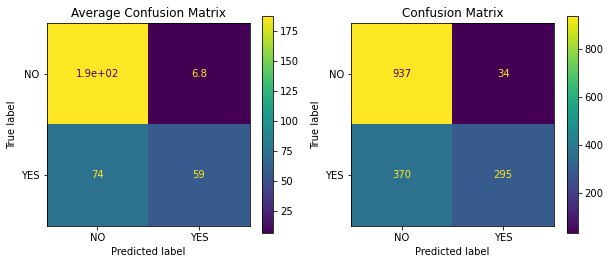

In [39]:
import sklearn
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax.set_title('Average Confusion Matrix')
ax1.set_title('Confusion Matrix')
cm_avg_plot = sklearn.metrics.ConfusionMatrixDisplay(cm_avg, display_labels=['NO', 'YES']).plot(ax=ax)
cm_all_plot = sklearn.metrics.ConfusionMatrixDisplay(cm_all, display_labels=['NO', 'YES']).plot(ax=ax1)

In [40]:
set(imp_fea_list)

{'COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK',
 'COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH',
 'COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR',
 'COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY',
 'COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE',
 'COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES',
 'COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED',
 'COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS',
 'COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS',
 'COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS_1:_APPLE',
 'COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE',
 'COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER',
 'COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP',
 'COGNITIVE_EXAM_162-187:_(178)_RECALLS_ADDRESS',
 'COGNITIVE_EXAM_162-187:_(179)_SIMILARITIES_-_FRUIT',
 'EST_SEVERITY_OF_DEMENTIA'}

In [41]:
{'ANXIETY/PHOBIC',
 'CAMCOG_REMOTE_MEMORY_SCORE',
 'CERBRO-VASCULAR_DISEASE_PRESENT',
 'CLINICAL_BACKGROUND:_BODY_MASS_INDEX',
 'COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK',
 'COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH',
 'COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR',
 'COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY',
 'COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN',
 'COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY',
 'COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE',
 'COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH',
 'COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO',
 'COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES',
 'COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER',
 'COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED',
 'COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE',
 'COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS',
 'COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS_3:_PENNY',
 'COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS',
 'COGNITIVE_EXAM_120-161:_(161)_RECALLS_OBJECTS_1:_APPLE',
 'COGNITIVE_EXAM_162-187:_(167)_CLOCK_DRAWING',
 'COGNITIVE_EXAM_162-187:_(168)_WRITES_A_SENTENCE',
 'COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER',
 'COGNITIVE_EXAM_162-187:_(169)_PRAXIS_-_PAPER:_ON_LAP',
 'COGNITIVE_EXAM_162-187:_(172)_MIME_-_WAVE',
 'COGNITIVE_EXAM_162-187:_(173)_MIME_-_SCISSORS',
 'COGNITIVE_EXAM_162-187:_(174)_MIME_-_BRUSHING_TEETH',
 'COGNITIVE_EXAM_162-187:_(178)_RECALLS_ADDRESS',
 'COGNITIVE_EXAM_162-187:_(179)_SIMILARITIES_-_FRUIT',
 'COGNITIVE_EXAM_162-187:_(182)_SIMILARITIES_-_LIFE',
 'COGNITIVE_EXAM_162-187:_(184)_RECOGNISES_OBJECTS',
 'COGNITIVE_EXAM_162-187:_(187)_PATIENT',
 'DEPRESSIVE_ILLNESS',
 'DIAGNOSTIC_CODE',
 'EST_OF_SEVERITY_OF_DEPRESSION',
 'EST_SEVERITY_OF_DEMENTIA',
 'PRESENT_STATE_47-73:_(058)_MEMORY_PROBLEM'}

{'ANXIETY/PHOBIC',
 'CAMCOG_REMOTE_MEMORY_SCORE',
 'CERBRO-VASCULAR_DISEASE_PRESENT',
 'CLINICAL_BACKGROUND:_BODY_MASS_INDEX',
 'COGNITIVE_EXAM_120-161:_(120)_IDENTIFIES_DAY_OF_WEEK',
 'COGNITIVE_EXAM_120-161:_(122)_IDENTIFIES_MONTH',
 'COGNITIVE_EXAM_120-161:_(123)_IDENTIFIES_YEAR',
 'COGNITIVE_EXAM_120-161:_(125)_IDENTIFIES_COUNTY',
 'COGNITIVE_EXAM_120-161:_(126)_IDENTIFIES_TOWN',
 'COGNITIVE_EXAM_120-161:_(127)_IDENTIFIES_STREETS/COUNTRY',
 'COGNITIVE_EXAM_120-161:_(129)_IDENTIFIES_PRESENT_PLACE',
 'COGNITIVE_EXAM_120-161:_(131)_COMPREHENDS_TOUCH',
 'COGNITIVE_EXAM_120-161:_(136)_COMPREHENDS_RADIO',
 'COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES',
 'COGNITIVE_EXAM_120-161:_(138)_NAMES_PICTURES:_TYPEWRITER',
 'COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED',
 'COGNITIVE_EXAM_120-161:_(139)_NUMBER_OF_ANIMALS_LISTED:_SCORE',
 'COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS',
 'COGNITIVE_EXAM_120-161:_(158)_REGISTERS_OBJECTS_3:_PENNY',
 'COGNITIVE_EXAM_120-161:_(161)_RECALLS_O